In [64]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, stft
from scipy.fft import rfft, fftfreq, rfftfreq, irfft
import pywt
from scipy.signal.windows import hann
from scipy.io import wavfile
import os
import glob
import librosa
from IPython.display import Audio

In [65]:
# Define the base folder path
base_folder_path = './train/'

# Function to get available folders
def get_folders(path):
    folders = [os.path.basename(f.path) for f in os.scandir(path) if f.is_dir()]
    return folders

# Function to get available files in the selected folder
def get_files_in_folder(folder):
    folder_path = os.path.join(base_folder_path, folder)
    files = glob.glob(os.path.join(folder_path, '*.wav'))
    return [os.path.basename(f).replace('.wav', '') for f in files]

# Asking user to select the folder
folders = get_folders(base_folder_path)
print("Available folders:", folders)
folder_choice = input("Please enter the folder you want to analyze (e.g., 'Normal' or 'Abnormal'): ").strip()

# Checking to see if the folder exists (case-insensitive)
if folder_choice.lower() not in [f.lower() for f in folders]:
    print("Invalid folder choice. Please restart the program and choose a valid folder.")
else:
    # Finding the exact folder name
    folder_choice = next(f for f in folders if f.lower() == folder_choice.lower())
    
    # Listing files in the selected folder
    files = get_files_in_folder(folder_choice)
    print("Available files in", folder_choice, "folder:", files)
    
    # Asking user to select the file
    file_choice = input("Please enter the file you want to analyze (without '.wav' extension): ").strip()
    
    # Checking to see if the file exists (case-insensitive)
    if file_choice.lower() not in [f.lower() for f in files]:
        print("Invalid file choice. Please restart the program and choose a valid file.")
    else:
        # Finding the exact file name (in case-sensitive form)
        file_choice = next(f for f in files if f.lower() == file_choice.lower())
        
        # Loading the selected file
        file_path = os.path.join(base_folder_path, folder_choice, f"{file_choice}.wav")
        fs, x = wavfile.read(file_path)  # fs is the sample rate, x is the data
        
        # Displaying some basic information and playing the audio
        print(f"Loaded file: {file_choice}.wav")
        print(f"Sample rate (fs): {fs} Hz")
        print(f"Data shape: {x.shape}")
        
        # Play the audio
        display(Audio(data=x, rate=fs))

Available folders: ['Abnormal', 'Normal']
Available files in Abnormal folder: ['(1)', '(11)', '(2)', '(3)', '(4)']
Loaded file: (4).wav
Sample rate (fs): 4000 Hz
Data shape: (25278,)


In [66]:
# Setting the target duration and initializing other parameters
L = 4 # Target duration set according to the shortest file
target_samples = None

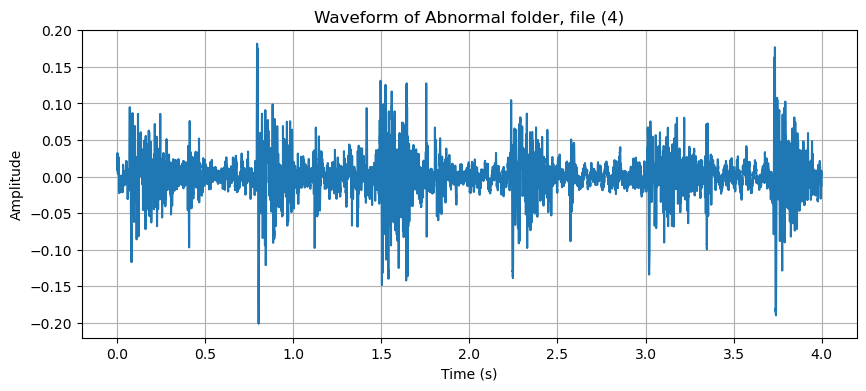

In [67]:
# Loading the selected file
x, fs = librosa.load(file_path, sr=None)  # Loading with the original sample rate

# Setting target_samples if not already set
if target_samples is None:
    target_samples = int(L * fs)  # Calculating target samples for 4 seconds

# Adjusting the signal length to match 4 seconds
if len(x) < target_samples:
    # Padding with zeros if shorter
    x = np.pad(x, (0, target_samples - len(x)), mode='constant')
elif len(x) > target_samples:
    # Truncating if longer
    x = x[:target_samples]

# Updating time axis for 4 seconds duration
t = np.arange(0, L, 1/fs)

# Plotting the audio waveform
plt.figure(figsize=(10, 4))
plt.plot(t, x)
plt.title(f"Waveform of {folder_choice} folder, file {file_choice}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Playing the audio
display(Audio(x, rate=fs))

In [68]:
#Computing Fast Fourier Transform (FFT) And Real-Valued FFT (RFFT) Of Signal x
Y = rfft(x) 

#Calculating Power Spectrum (PSD)
PSD = np.abs(Y)
freqs = rfftfreq(t.size, 1/fs)

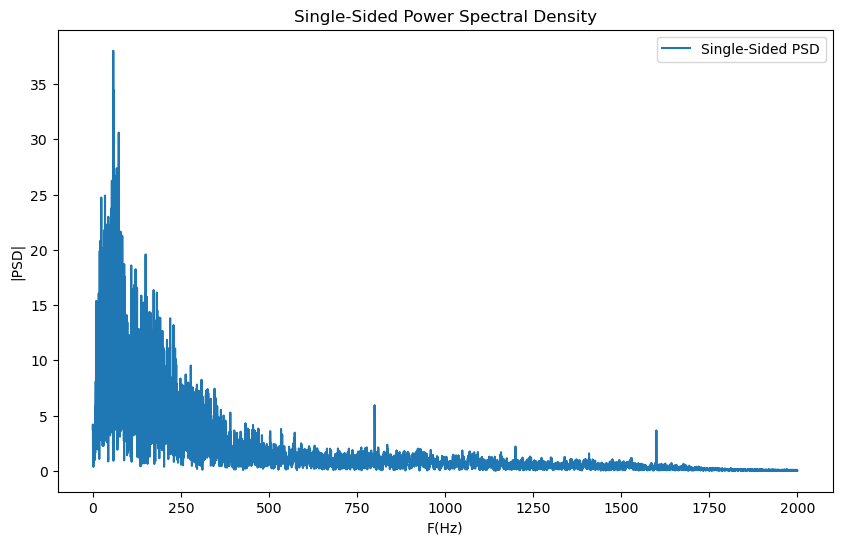

In [69]:
#Plotting Single-Sided Power Spectral Density
plt.figure(figsize = (10, 6))
plt.plot(freqs, PSD, label = 'Single-Sided PSD')
plt.title('Single-Sided Power Spectral Density')
plt.xlabel('F(Hz)')
plt.ylabel('|PSD|')
plt.legend(fontsize = 10, loc = 'upper right')
plt.show()

In [78]:
#Assigning Threshold Value
threshold = 10

In [79]:
#Finding Freqs With Large PSD
#Taking Out Small Fourier Coeffs In Y
indices = PSD > threshold
Y_zeroed = indices * Y

In [80]:
#Assigning Filtered FFT (FFILT) Value
#Inverseing FFT For Filtered Time Signal
ffilt = irfft(Y_zeroed)

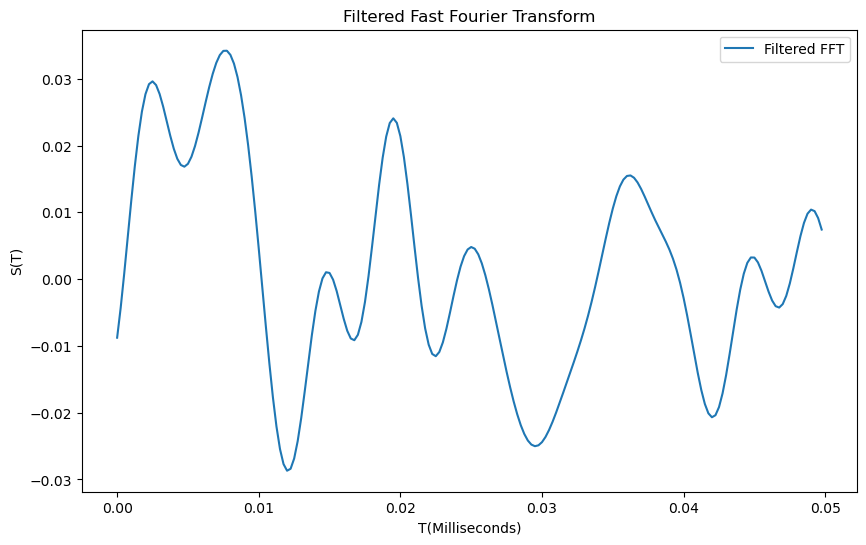

In [81]:
#Plotting First 200 FFILT Data Points
plt.figure(figsize = (10, 6))
plt.plot(t[:200], ffilt[:200], label = 'Filtered FFT')
plt.title('Filtered Fast Fourier Transform')
plt.xlabel('T(Milliseconds)')
plt.ylabel('S(T)')
plt.legend(fontsize = 10, loc = 'upper right')
plt.show()

In [82]:
#Defining Size Of Average Filter Kernel
kernel_size = 15

In [83]:
#Creating Average Filter Kernel
average_kernel = np.ones(kernel_size) / 15

In [84]:
#Convolving Signal With Average Filter Kernel
x_filtered = np.convolve(average_kernel, x, mode = 'same')

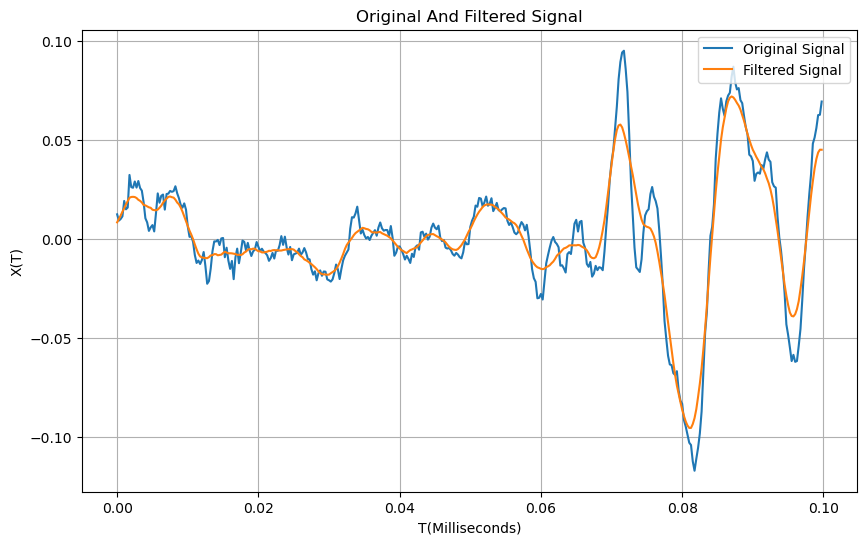

In [85]:
#Plotting First 400 Points Of Original And Filtered Signal
plt.figure(figsize = (10, 6))
plt.plot(t[:400], x[:400], label = 'Original Signal')
plt.plot(t[:400], x_filtered[:400], 'tab:orange', label = 'Filtered Signal')
plt.title('Original And Filtered Signal')
plt.xlabel('T(Milliseconds)')
plt.ylabel('X(T)')
plt.legend(fontsize = 10, loc = 'upper right')
plt.grid()
plt.show()

display(Audio(data=x_filtered, rate=fs))

In [86]:
#Defining Parameters Of Gaussian Filter
#Standard Deviation (SD) Of Gaussian Distribution
sigma = 1.0

#Filter Size
filter_size = 9

In [87]:
#Creating Array Representing 1D Gaussian Kernel
z = np.linspace(-filter_size // 2, filter_size // 2, filter_size)
gaussian_kernel = np.exp(-z ** 2 / (2 * sigma ** 2))
norm_gaussian_kernel = gaussian_kernel / np.sum(gaussian_kernel)  

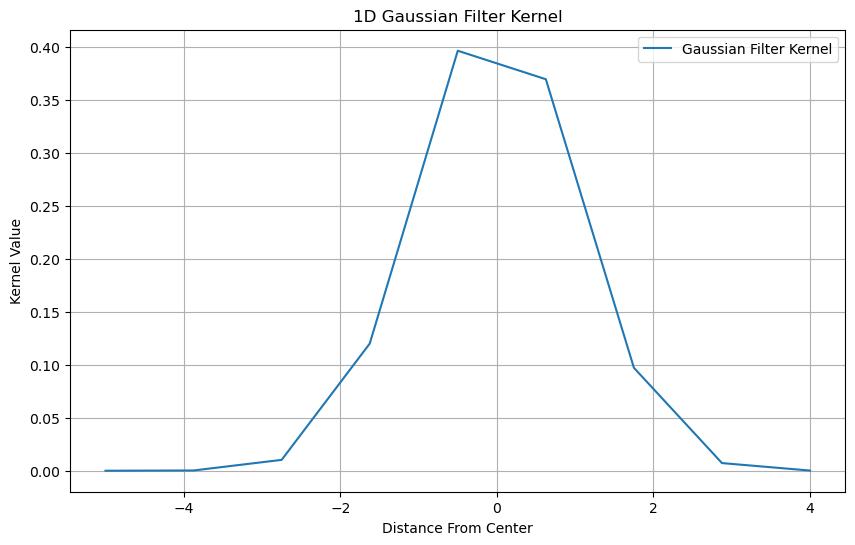

In [88]:
#Plotting Gaussian Kernel
plt.figure(figsize = (10, 6))
plt.plot(z, norm_gaussian_kernel, label = 'Gaussian Filter Kernel')
plt.title('1D Gaussian Filter Kernel')
plt.xlabel('Distance From Center')
plt.ylabel('Kernel Value')
plt.legend(fontsize = 10, loc = 'upper right')
plt.grid()
plt.show()

In [89]:
#Convolving Signal With Average Filter Kernel
x_smoothed = np.convolve(norm_gaussian_kernel, x, mode = 'same')

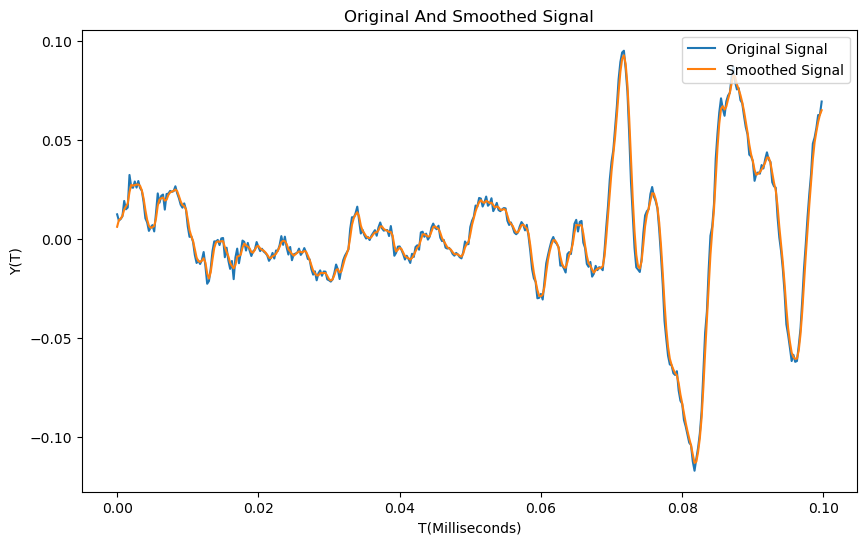

In [90]:
#Plotting First 400 Points Of Original And Smoothed Signal
plt.figure(figsize = (10, 6))
plt.plot(t[:400], x[:400], label = 'Original Signal')
plt.plot(t[:400], x_smoothed[:400], 'tab:orange', label = 'Smoothed Signal')
plt.title('Original And Smoothed Signal')
plt.xlabel('T(Milliseconds)')
plt.ylabel('Y(T)')
plt.legend(fontsize = 10, loc = 'upper right')
plt.show()

display(Audio(data=x_smoothed, rate=fs))

In [91]:
#Autocorrelation Of Exponential Sequences
a = 0.95
N = 28
n = np.arange(0, N)
lags = np.arange(-(N-1), N)

s = a ** n
c_auto_corr = np.correlate(s, s, mode = 'full')

In [92]:
#C Analytically Estimated
nn = np.arange(-(N-1), N, 1/fs)
c_analytical = (1 - a**(2*(N-np.abs(nn)))) / (1 - a**2) * a**np.abs(nn)

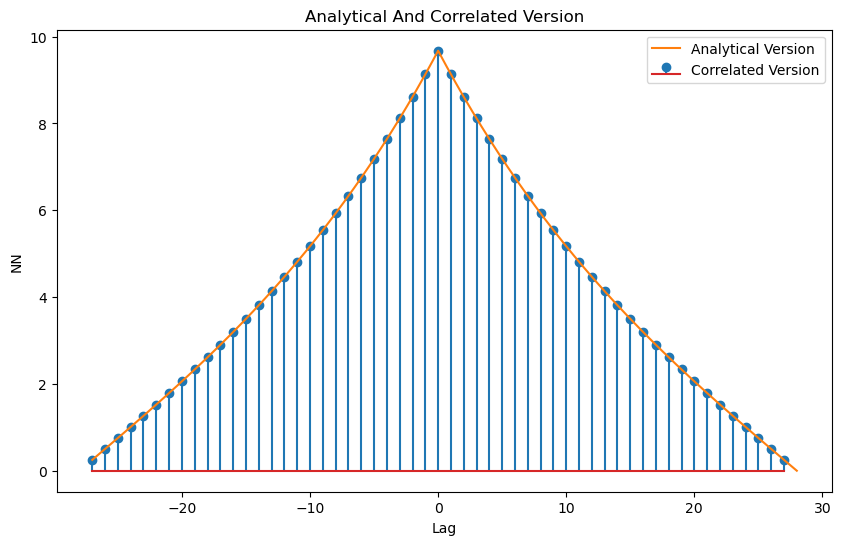

In [93]:
#Plotting Analytical And Correlated Version
plt.figure(figsize = (10, 6))
plt.stem(lags, c_auto_corr, label = 'Correlated Version')
plt.plot(nn, c_analytical, 'tab:orange', label = 'Analytical Version')
plt.title('Analytical And Correlated Version')
plt.xlabel('Lag')
plt.ylabel('NN')
plt.legend(fontsize = 10, loc = 'upper right')
plt.show()

In [94]:
dt = 1/fs
T = np.arange(0, L, dt)
T = np.linspace(0, len(x) / fs, len(x))


In [95]:
#Length Of Window
M = 128

#Window
g = hann(M, sym = False)

#Overlap Of Window
L = 0.75 * M

#Length Of FFT
Ndft = 128

In [96]:
#Using Spectrogram With Explicit Parameters
fx, tx, sx = spectrogram(x, fs = fs, window = g, nperseg = M, noverlap = int(L), nfft = Ndft, scaling = 'spectrum')

In [97]:
#Using STFT With Explicit Parameters
ft, tt, st = stft(x, fs = fs, window = g, noverlap = int(L), nperseg = M, nfft = Ndft, boundary = None, padded = False, scaling = 'spectrum')

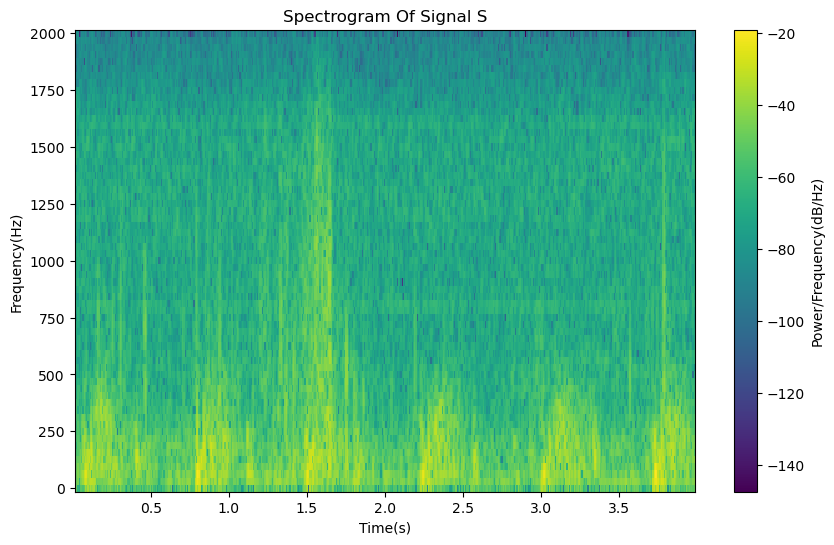

In [98]:
#Plotting Spectrogram
plt.figure(figsize = (10, 6))
#Converting To dB
plt.pcolormesh(tx, fx, 10 * np.log10(np.abs(sx)), shading = 'auto')
plt.title('Spectrogram Of Signal S')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.colorbar(label = 'Power/Frequency(dB/Hz)')
plt.show()

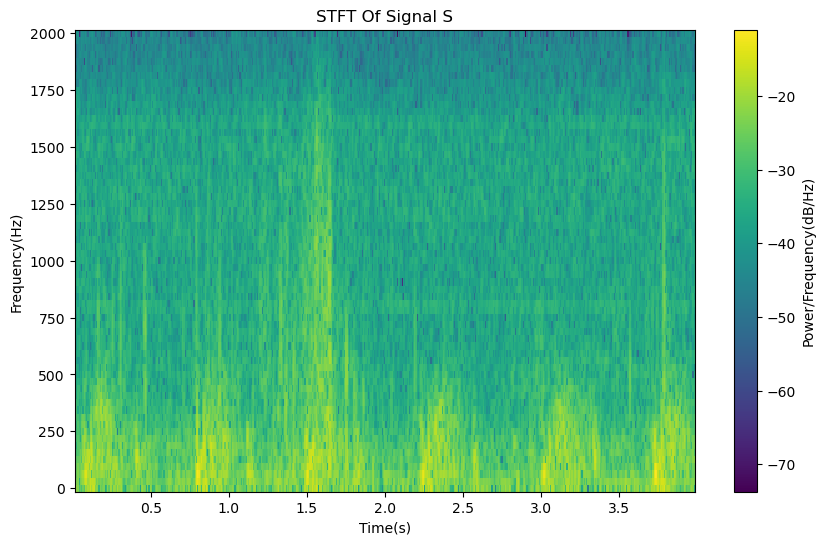

In [99]:
#Plotting STFT
plt.figure(figsize = (10, 6))
#Converting To dB
plt.pcolormesh(tt, ft, 10 * np.log10(np.abs(st)), shading = 'auto')
plt.title('STFT Of Signal S')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.colorbar(label = 'Power/Frequency(dB/Hz)')
plt.show()

In [100]:
#Performing Continuous Wavelet Transform (CWT)
wavelet = 'morl'
scales = np.arange(1, 128)
cwt_results, frequencies = pywt.cwt(x, scales, wavelet)

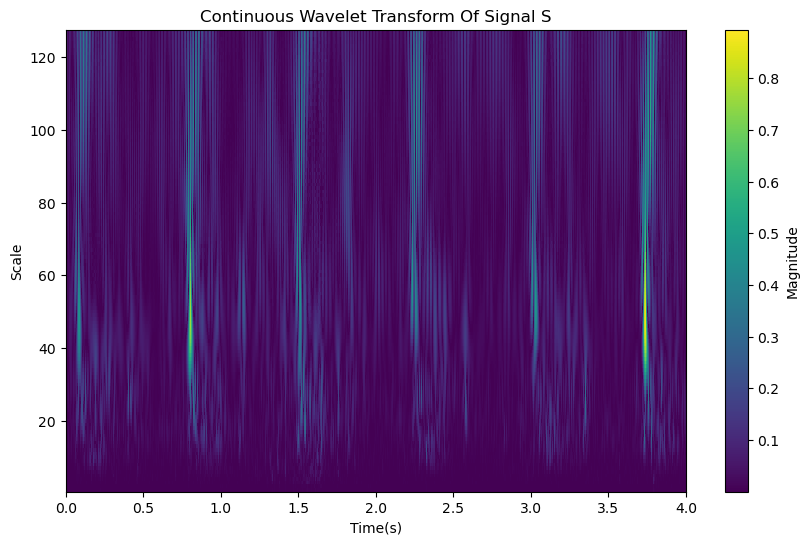

In [101]:
#Plotting CWT Results
plt.figure(figsize = (10, 6))
plt.pcolormesh(T, scales, np.abs(cwt_results), shading = 'auto')
plt.title('Continuous Wavelet Transform Of Signal S')
plt.xlabel('Time(s)')
plt.ylabel('Scale')
plt.colorbar(label = 'Magnitude')
plt.show()